># Xception

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !unzip '/content/drive/MyDrive/Dataset/data.zip'

In [5]:
gpus = tf.config.list_logical_devices('GPU')
stg=tf.distribute.MirroredStrategy(gpus)

Found 8320 images belonging to 38 classes.
Found 2059 images belonging to 38 classes.
Epoch 1/50
260/260 [==============================] - 257s 700ms/step - loss: 2.2915 - accuracy: 0.3722 - val_loss: 0.8795 - val_accuracy: 0.7266 - lr: 1.0000e-04
Epoch 2/50
260/260 [==============================] - 194s 746ms/step - loss: 0.5762 - accuracy: 0.8248 - val_loss: 0.7082 - val_accuracy: 0.7960 - lr: 1.0000e-04
Epoch 3/50
260/260 [==============================] - 184s 709ms/step - loss: 0.3397 - accuracy: 0.9007 - val_loss: 0.5769 - val_accuracy: 0.8368 - lr: 1.0000e-04
Epoch 4/50
260/260 [==============================] - 187s 721ms/step - loss: 0.2404 - accuracy: 0.9264 - val_loss: 0.6359 - val_accuracy: 0.8286 - lr: 1.0000e-04
Epoch 5/50
260/260 [==============================] - 183s 703ms/step - loss: 0.2000 - accuracy: 0.9400 - val_loss: 0.6030 - val_accuracy: 0.8456 - lr: 1.0000e-04
Epoch 6/50
260/260 [==============================] - ETA: 0s - loss: 0.1570 - accuracy: 0.9536
Epo

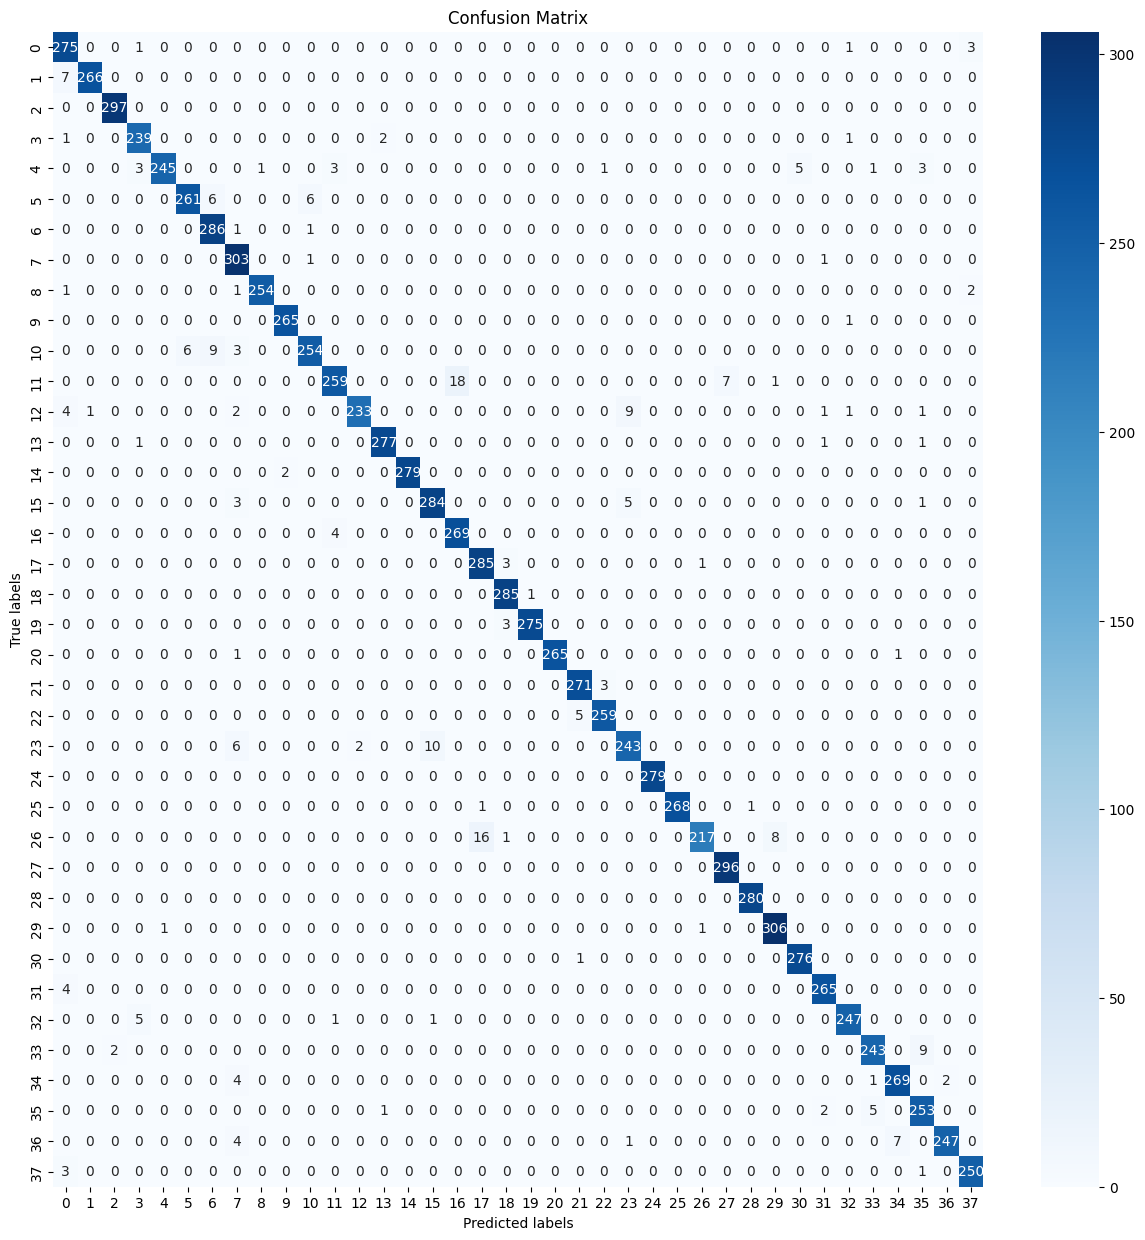

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       280
           1       1.00      0.97      0.99       273
           2       0.99      1.00      1.00       297
           3       0.96      0.98      0.97       243
           4       1.00      0.94      0.96       262
           5       0.98      0.96      0.97       273
           6       0.95      0.99      0.97       288
           7       0.92      0.99      0.96       305
           8       1.00      0.98      0.99       258
           9       0.99      1.00      0.99       266
          10       0.97      0.93      0.95       272
          11       0.97      0.91      0.94       285
          12       0.99      0.92      0.96       252
          13       0.99      0.99      0.99       280
          14       1.00      0.99      1.00       281
          15       0.96      0.97      0.97       293
          16       0.94      0.99      0.96       273
    

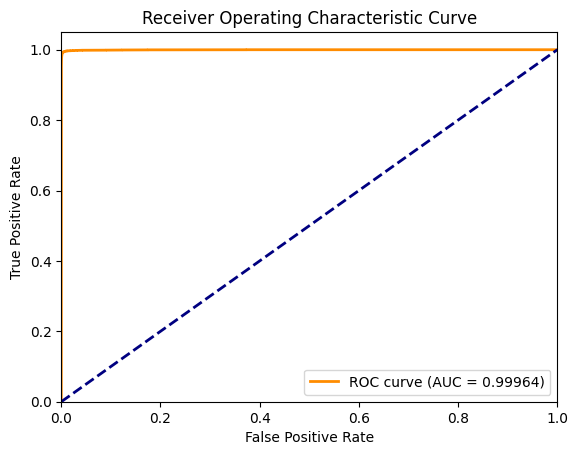

In [16]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define directories and parameters
folder_dir = '/content/data'
SIZE = 224
no_of_classes = 38
batch_size = 32
picture_size = (SIZE, SIZE)
epochs = 50  # Increase number of epochs

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,  # Increased rotation range
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,  # Added shear range
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_set = train_datagen.flow_from_directory(
    directory=folder_dir,
    target_size=picture_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=22
)

validation_set = train_datagen.flow_from_directory(
    directory=folder_dir,
    target_size=picture_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=22
)

# Model building
base_model = Xception(weights="imagenet", input_shape=(SIZE, SIZE, 3), include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)  # Increased dense layer size
predictions = Dense(no_of_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
    metrics=['accuracy']
)

# Training
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1)
callbacks = [lr_scheduler, early_stopping]

history = model.fit(
    train_set,
    epochs=epochs,
    validation_data=validation_set,
    callbacks=callbacks
)

# Evaluate on test set
test_data_dir = '/content/data'
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=picture_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate_generator(test_generator)
print('Test accuracy:', test_acc)

# Compute and display metrics
predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred))

roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), predictions, average='macro')
print("Overall ROC AUC Score:", roc_auc)

fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(y_true).ravel(), predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()
